In [1]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pysmt.shortcuts import Symbol, And, Equals, Real, GT, Max, Plus, get_model
from pysmt.typing import REAL

In [2]:
class Model(nn.Module):
    def __init__(self, embedding_size):
        super(Model, self).__init__()             
        self.linear0 = nn.Linear(3, embedding_size)
        self.linear1 = nn.Linear(embedding_size, 1)
        self.linear_layers = [self.linear0, self.linear1]
        self.relu = nn.ReLU()
        
    def forward(self, x):   
        x = self.linear0(x)
        x = self.relu(x)  
        
        x = self.linear1(x)
        
        return x[0]

In [3]:
def train_backpropagation(model, all_data, labels, criterion, optimizer, num_epochs):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        num_correct = 0
    
        for (data, label) in zip(all_data, labels): 
            optimizer.zero_grad()
        
            output = model(data)
            prediction = 1 if output > 0 else 0

            loss = criterion(output, label)
            num_correct += (label == prediction)
        
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss = running_loss/len(labels)
        accuracy = num_correct/len(labels)
        print("epoch: " + str(epoch) + ", accuracy: " + str(accuracy.item()) + ", loss: " + str(loss))
        
        if (accuracy == 1.0):
            return

In [4]:
def train_smt(model, all_data, labels):
    
    layers_weights = []
    num_layers = len(model.linear_layers)
    for i in range(num_layers):
        num_rows = len(model.linear_layers[i].weight.data)
        num_cols = len(model.linear_layers[i].weight.data[0])
        layer_weights = []
        for j in range(num_rows):
            weights = []
            for k in range(num_cols):
                weights.append(Symbol("weight_" + str(i) + "_" + str(j) + "_" + str(k), REAL))
            weights.append(Symbol(str("bias_" + str(i) + "_" + str(j)), REAL))
            layer_weights.append(weights)
        layers_weights.append(layer_weights)

    equations = []
    for (data, label) in zip(all_data, labels):
        x = []
        for value in data:
            x.append(Real(value.item()))
            
        for i in range(num_layers):
            num_rows = len(model.linear_layers[i].weight.data)
            num_cols = len(model.linear_layers[i].weight.data[0])
            new_x = []
            for j in range(num_rows):
                calculations = []
                for k in range(num_cols):
                    calculation = layers_weights[i][j][k] * x[k]
                    calculations.append(calculation)
                calculations.append(layers_weights[i][j][num_cols])
                output = Plus(calculations)
                if i < num_layers-1:
                    output = Max(output, Real(0.0))
                new_x.append(output)
            x = new_x
    
        if label.item() == 0.0:
            equation = Equals(x[0], Real(0.0))
        else:
            equation = GT(x[0], Real(0.0))
            
        equations.append(equation)

    formula = And(equations)
    solution = get_model(formula)
    
    if solution:
        for i in range(num_layers):
            num_rows = len(model.linear_layers[i].weight.data)
            num_cols = len(model.linear_layers[i].weight.data[0])
            for j in range(num_rows):
                for k in range(num_cols):
                    weight = layers_weights[i][j][k]
                    weight_solution = solution[weight].constant_value()
                    model.linear_layers[i].weight.data[j][k] = float(weight_solution)
    
                
                bias = layers_weights[i][j][num_cols]
                bias_solution = solution[bias].constant_value()
                model.linear_layers[i].bias.data[j] = float(bias_solution)

    else:
        print("No solution found")

In [5]:
def test(model, all_data, labels, criterion): 
    running_loss = 0.0
    num_correct = 0
    
    for (data, label) in zip(all_data, labels): 
        output = model(data)
        prediction = 1 if output > 0 else 0

        loss = criterion(output, label)
        num_correct += (label == prediction)
        
        running_loss += loss.item()

    loss = running_loss/len(labels)
    accuracy = num_correct/len(labels)
    
    print("testing accuracy: " + str(accuracy.item()) + " and loss: " + str(loss))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

points = torch.tensor([[-1.0, -1.0, -1.0], [1.0, -1.0, -1.0], [-1.0, 1.0, -1.0], [-1.0, -1.0, 1.0],
                       [1.0, 1.0, 1.0], [-1.0, 1.0, 1.0], [1.0, -1.0, 1.0], [1.0, 1.0, -1.0],])

labels = torch.tensor([0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], requires_grad=True)

#TODO: use cross entropy
criterion = nn.BCEWithLogitsLoss()
num_epochs = 1000

In [11]:
embedding_sizes = [20, 40, 60, 80, 100]
#embedding_sizes = [50, 100, 150, 200]
smt_times = []
backpropagation_times = []

for embedding_size in embedding_sizes:
    
    print("embedding_size: ", embedding_size)

    model = Model(embedding_size)
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    model.to(device)

    start_time = time.time()
    train_backpropagation(model, points, labels, criterion, optimizer, num_epochs)
    backpropagation_times.append(time.time() - start_time)

    start_time = time.time()
    train_smt(model, points, labels)
    smt_times.append(time.time() - start_time)
    test(model, points, labels, criterion)

embedding_size:  20
epoch: 0, accuracy: 0.25, loss: 0.8198045343160629
epoch: 1, accuracy: 0.375, loss: 0.7171641066670418
epoch: 2, accuracy: 0.625, loss: 0.6420148834586143
epoch: 3, accuracy: 0.625, loss: 0.5736764222383499
epoch: 4, accuracy: 0.875, loss: 0.505476251244545
epoch: 5, accuracy: 1.0, loss: 0.4380674809217453
testing accuracy: 1.0 and loss: 0.4462390876803052
embedding_size:  40
epoch: 0, accuracy: 0.75, loss: 0.5829505436122417
epoch: 1, accuracy: 1.0, loss: 0.37375959008932114
testing accuracy: 1.0 and loss: 0.3473854020817271
embedding_size:  60
epoch: 0, accuracy: 0.5, loss: 0.6916396208107471
epoch: 1, accuracy: 1.0, loss: 0.3768772967159748
testing accuracy: 0.875 and loss: 0.40408675762509105
embedding_size:  80
epoch: 0, accuracy: 0.75, loss: 0.6585815735161304
epoch: 1, accuracy: 1.0, loss: 0.2952108606696129
testing accuracy: 1.0 and loss: 0.3797453932243684
embedding_size:  100
epoch: 0, accuracy: 0.625, loss: 0.6612904630601406
epoch: 1, accuracy: 1.0, loss

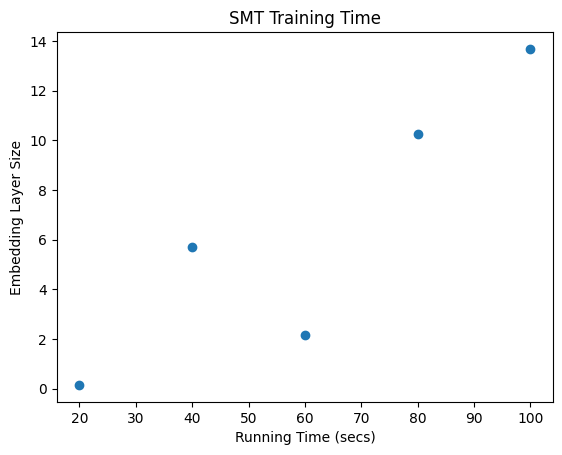

In [16]:
plt.scatter(embedding_sizes, smt_times)
plt.title("SMT Training Time")
plt.xlabel("Running Time (secs)")
plt.ylabel("Embedding Layer Size")
plt.show()

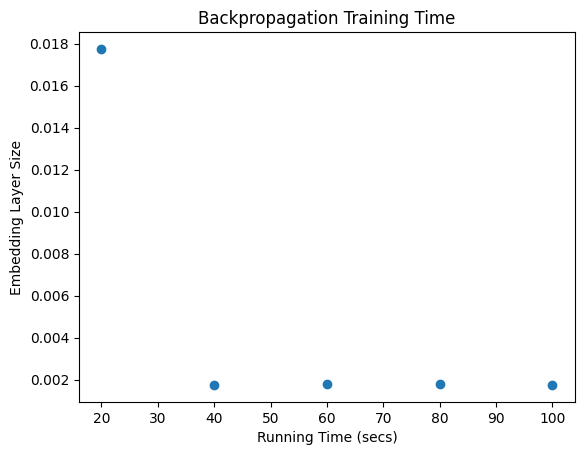

In [17]:
plt.scatter(embedding_sizes, backpropagation_times)
plt.title("Backpropagation Training Time")
plt.xlabel("Running Time (secs)")
plt.ylabel("Embedding Layer Size")
plt.show()